In [86]:
import pandas as pd
import numpy as np

# Graphing
from graph_config import plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

#stats
from statsmodels.tsa.seasonal import STL

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


### Turbine & Wind Data — Final Column Dictionary

| Column Name                     | Data Type | Unit | Description                                                                          |
| ------------------------------- | --------- | ---- | ------------------------------------------------------------------------------------ |
| `turbine_power_kw`              | `float`   | kW   | Actual power output from the turbine (baseline telemetry).                           |
| `turbine_setpoint_kw`           | `float`   | kW   | Target or allowed power output set by the turbine controller or grid signal.         |
| `wind_baseline_ms`              | `float`   | m/s  | Measured wind speed from the turbine sensor (baseline).                              |
| `wind_scraped_ms`               | `float`   | m/s  | Wind speed scraped from a weather data source.                                       |
| `wind_scraped_scaled_ms`        | `float`   | m/s  | Scraped wind corrected using a linear regression model.                              |
| `wind_scraped_is_interpolated`  | `boolean` | -    | `True` if `wind_scraped_ms` was filled via short-gap interpolation.                  |
| `wind_baseline_is_interpolated` | `boolean` | -    | `True` if `wind_baseline_ms` was filled via short-gap interpolation.                 |
| `wind_final_ms`                 | `float`   | m/s  | Final selected wind speed (`wind_baseline_ms` or corrected `wind_scraped_ms`).       |
| `wind_final_source`             | `string`  | -    | Source of `wind_final_ms`: `"baseline"` or `"scraped"`.                              |
| `turbine_power_predicted_kw`    | `float`   | kW   | Power estimated from `wind_final_ms` using a Weibull power model.                    |
| `turbine_power_final_kw`        | `float`   | kW   | Final selected power: either `turbine_power_kw` or `turbine_power_predicted_kw`.     |
| `turbine_power_final_source`    | `string`  | -    | Source of `turbine_power_final_kw`: `"baseline"`, `"predicted"`, or `"turbine_off"`. |
| `turbine_energy_kwh`            | `float`   | kWh  | Energy output during the 30-minute interval (`turbine_power_final_kw × 0.5`).        |


In [108]:
# Load turbine telemetry dataset
ts_tt = pd.read_csv(PROCESSED_DATASET_PATH / '250411_turbine_telemetry_dataset_v1.csv', index_col=0)

# set NaN values in Turbine_power_kw and Turbine_energy_kWh to 0
ts_tt['turbine_power_kw'] = ts_tt['turbine_power_kw'].fillna(0)
ts_tt['turbine_energy_kwh'] = ts_tt['turbine_energy_kwh'].fillna(0) 

ts_tt.head()

,turbine_power_kw,turbine_setpoint_kw,wind_baseline_ms,wind_scraped_ms,wind_scraped_is_interpolated,wind_baseline_is_interpolated,wind_scraped_scaled_ms,wind_final_ms,wind_final_source,turbine_power_predicted_kw,turbine_power_final_kw,turbine_power_final_source,turbine_energy_kwh
Timestamp,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,889.766667,baseline,444.883333
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,893.266667,baseline,446.633333
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,897.633333,baseline,448.816667
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,899.966667,baseline,449.983333
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,900.000000,baseline,450.000000


# Residential Demand Data — Final Column Dictionary

| Column Name                    | Data Type  | Unit | Description                                                                                     |
| ------------------------------ | ---------- | ---- | ----------------------------------------------------------------------------------------------- |
| `timestamp`                    | `datetime` | -    | Start time of the 30-minute interval (index of the dataframe).                                  |
| `res_demand_avg_kw`            | `float`    | kW   | Average residential power demand during the interval.                                           |
| `res_n_households`             | `integer`  | -    | Number of residential households connected at that time.                                        |
| `res_energy_per_household_kwh` | `float`    | kWh  | Estimated energy consumed per household in the interval.                                        |
| `res_energy_total_kwh`         | `float`    | kWh  | Total residential energy demand in the interval (`res_demand_avg_kw × 0.5 × res_n_households`). |
| `season`                       | `string`   | -    | Meteorological season (`"Winter"`, `"Spring"`, `"Summer"`, `"Autumn"`).                         |
| `hour`                         | `integer`  | h    | Hour of the day (0–23) corresponding to the timestamp.                                          |
| `day`                          | `date`     | -    | Calendar day of the observation (same as `date`, included if used separately).                  |
| `date`                         | `date`     | -    | Date portion of the timestamp.                                                                  |
| `time`                         | `time`     | -    | Time portion of the timestamp.                                                                  |

In [107]:
# load residential demand dataset
ts_rd = pd.read_csv(PROCESSED_DATASET_PATH / '250411_residential_demand_dataset_v1.csv', index_col=0)
ts_rd.head()

,res_demand_avg_kw,res_n_households,res_energy_per_household_kwh,res_energy_total_kwh,season,hour,day
Timestamp,,,,,,,
2017-01-01 00:00:00,0.220106,5428,0.110053,597.3690,Winter,0,2017-01-01
2017-01-01 00:30:00,0.205945,5429,0.102973,559.0380,Winter,0,2017-01-01
2017-01-01 01:00:00,0.189090,5429,0.094545,513.2845,Winter,1,2017-01-01
2017-01-01 01:30:00,0.173118,5429,0.086559,469.9290,Winter,1,2017-01-01
2017-01-01 02:00:00,0.159051,5429,0.079525,431.7430,Winter,2,2017-01-01


In [109]:
print(f'Residential demand and turbine telemetry datasets have same rows: {ts_rd.shape[0] == ts_tt.shape[0]}')

ts_rd.shape, ts_tt.shape

Residential demand and turbine telemetry datasets have same rows: True


((17568, 7), (17568, 13))

# Merge Datasetr

In [110]:
ts_combined = ts_tt.merge(
    ts_rd,
    how='inner',
    left_index=True,
    right_index=True
)

ts_combined.index = pd.to_datetime(ts_combined.index)
ts_combined.head()

,turbine_power_kw,turbine_setpoint_kw,wind_baseline_ms,wind_scraped_ms,wind_scraped_is_interpolated,wind_baseline_is_interpolated,wind_scraped_scaled_ms,wind_final_ms,wind_final_source,turbine_power_predicted_kw,turbine_power_final_kw,turbine_power_final_source,turbine_energy_kwh,res_demand_avg_kw,res_n_households,res_energy_per_household_kwh,res_energy_total_kwh,season,hour,day
Timestamp,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,889.766667,baseline,444.883333,0.220106,5428,0.110053,597.3690,Winter,0,2017-01-01
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,893.266667,baseline,446.633333,0.205945,5429,0.102973,559.0380,Winter,0,2017-01-01
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,897.633333,baseline,448.816667,0.189090,5429,0.094545,513.2845,Winter,1,2017-01-01
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,899.966667,baseline,449.983333,0.173118,5429,0.086559,469.9290,Winter,1,2017-01-01
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,900.000000,baseline,450.000000,0.159051,5429,0.079525,431.7430,Winter,2,2017-01-01


# Curtailment

In [111]:
N_turbine = 150
Max_export = 40 # MWh
Max_export_kwh = Max_export * 1000 # kWh

ts_combined['turbine_energy_total_kwh'] = ts_combined['turbine_energy_kwh'] * N_turbine

ts_combined['export_energy_available_kwh'] = (ts_combined['turbine_energy_total_kwh'] - ts_combined['turbine_energy_kwh']).clip(lower=0)

ts_combined['export_energy_actual_kwh'] = ts_combined['export_energy_available_kwh'].clip(upper=Max_export_kwh)

ts_combined['curtailment_energy_kwh'] = (ts_combined['turbine_energy_total_kwh'] - ts_combined['res_energy_total_kwh'] - ts_combined['export_energy_actual_kwh']).clip(lower=0)

ts_combined.head()

,turbine_power_kw,turbine_setpoint_kw,wind_baseline_ms,wind_scraped_ms,wind_scraped_is_interpolated,wind_baseline_is_interpolated,wind_scraped_scaled_ms,wind_final_ms,wind_final_source,turbine_power_predicted_kw,...,res_n_households,res_energy_per_household_kwh,res_energy_total_kwh,season,hour,day,turbine_energy_total_kwh,export_energy_available_kwh,export_energy_actual_kwh,curtailment_energy_kwh
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,...,5428,0.110053,597.3690,Winter,0,2017-01-01,66732.5,66287.616667,40000.0,26135.1310
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,...,5429,0.102973,559.0380,Winter,0,2017-01-01,66995.0,66548.366667,40000.0,26435.9620
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,...,5429,0.094545,513.2845,Winter,1,2017-01-01,67322.5,66873.683333,40000.0,26809.2155
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,...,5429,0.086559,469.9290,Winter,1,2017-01-01,67497.5,67047.516667,40000.0,27027.5710
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,...,5429,0.079525,431.7430,Winter,2,2017-01-01,67500.0,67050.000000,40000.0,27068.2570


## ‼️ New Column Added

| Column Name                    | Data Type  | Unit | Description                                                                  |
| ------------------------------ | ---------- | ---- | ---------------------------------------------------------------------------- |
| `turbine_energy_total_kwh`     | `float`    | kWh  | Cumulative energy generated by all turbine                                   |
| `export_energy_available_kwh`  | `float`    | kWh  | Amount of energy that could be exported to the grid.                         |
| `export_energy_actual_kwh`     | `float`    | kWh  | Actual energy exported to the grid.                                          |
| `curtailment_energy_kwh`       | `float`    | kWh  | **Excess generated energy that could not be used by households or exported to the grid. Calculated as:** `max(Turbine_energy_kWh - Energy_kwh_total - Exported_kwh, 0)` |



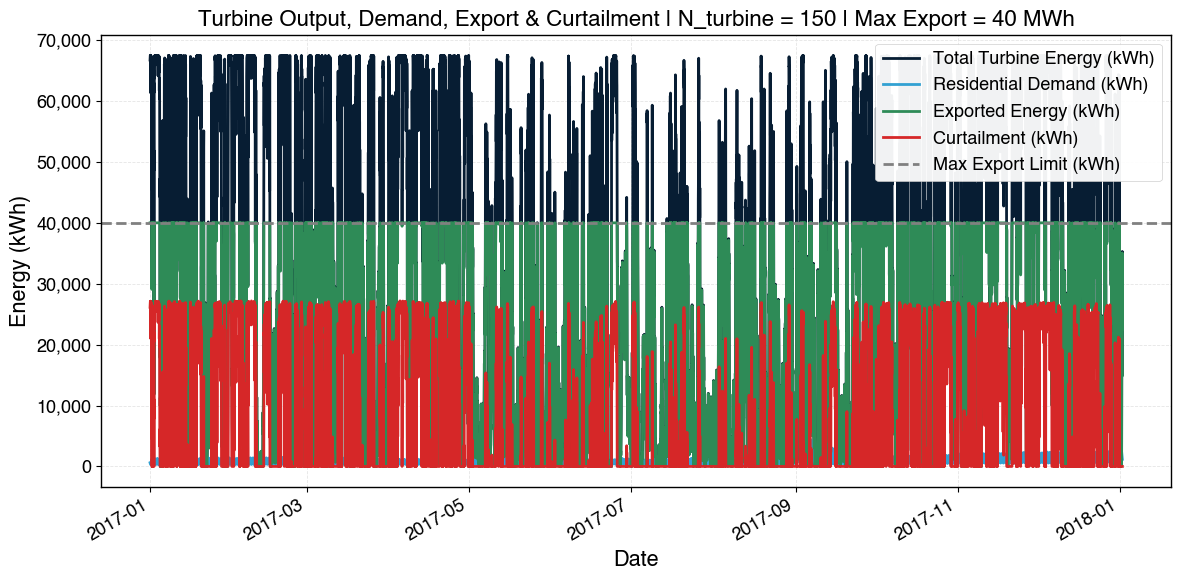

In [112]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ts_combined.index, ts_combined['turbine_energy_total_kwh'], '-', color='#071D33', label='Total Turbine Energy (kWh)')
ax.plot(ts_combined.index, ts_combined['res_energy_total_kwh'], '-', color='#32A1D2', label='Residential Demand (kWh)')
ax.plot(ts_combined.index, ts_combined['export_energy_actual_kwh'], '-', color='#2E8B57', label='Exported Energy (kWh)')  # SeaGreen
ax.plot(ts_combined.index, ts_combined['curtailment_energy_kwh'], '-', color='#D62728', label='Curtailment (kWh)')  # Red
ax.axhline(y=Max_export_kwh, color='gray', linestyle='--', label='Max Export Limit (kWh)')

ax.set_title(f'Turbine Output, Demand, Export & Curtailment | N_turbine = {N_turbine} | Max Export = {Max_export} MWh', fontsize=16)

# Format y-axis with comma-separated thousands
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Date')
ax.set_ylabel('Energy (kWh)')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()



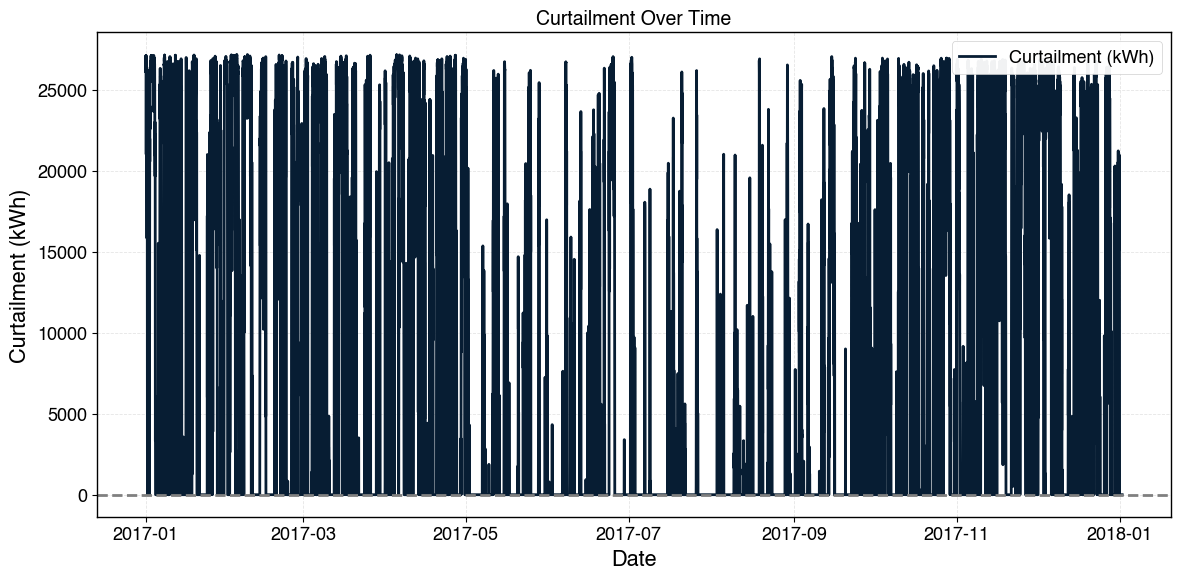

In [113]:
# Plot Curtailment
plt.figure(figsize=(12, 6))
plt.plot(ts_combined.index, ts_combined['curtailment_energy_kwh'], '-', label='Curtailment (kWh)')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Curtailment Over Time')
plt.xlabel('Date')
plt.ylabel('Curtailment (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

## Analysis

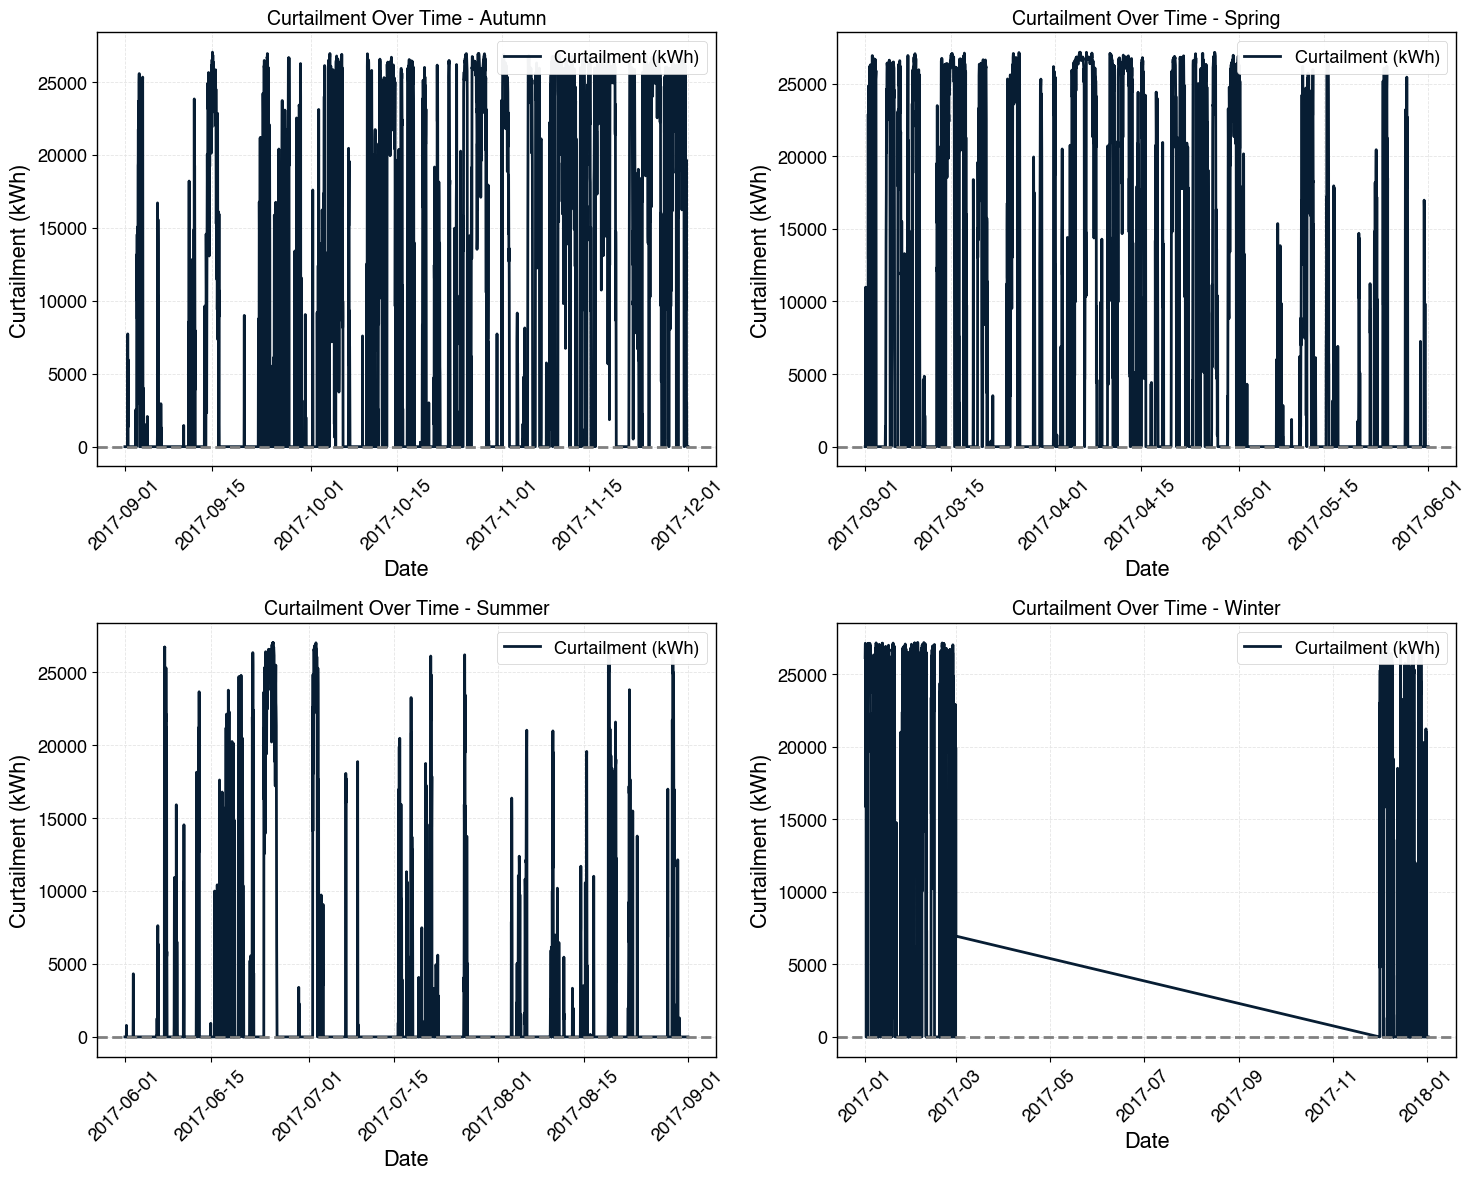

In [114]:
# Curtailment Over different season
seasons = sorted(ts_combined['season'].unique())  # Optional: sort seasons for consistent order
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=False)

for i, season in enumerate(seasons):
    row, col = i // 2, i % 2
    ts_season = ts_combined[ts_combined['season'] == season]
    
    axs[row, col].plot(ts_season.index, ts_season['curtailment_energy_kwh'], '-', label='Curtailment (kWh)')
    axs[row, col].axhline(y=0, color='gray', linestyle='--')
    axs[row, col].set_title(f'Curtailment Over Time - {season}', fontsize=14)
    axs[row, col].set_xlabel('Date')
    # roate x-axis labels
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].set_ylabel('Curtailment (kWh)')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Average Curtailment by Hour'}, xlabel='hour'>

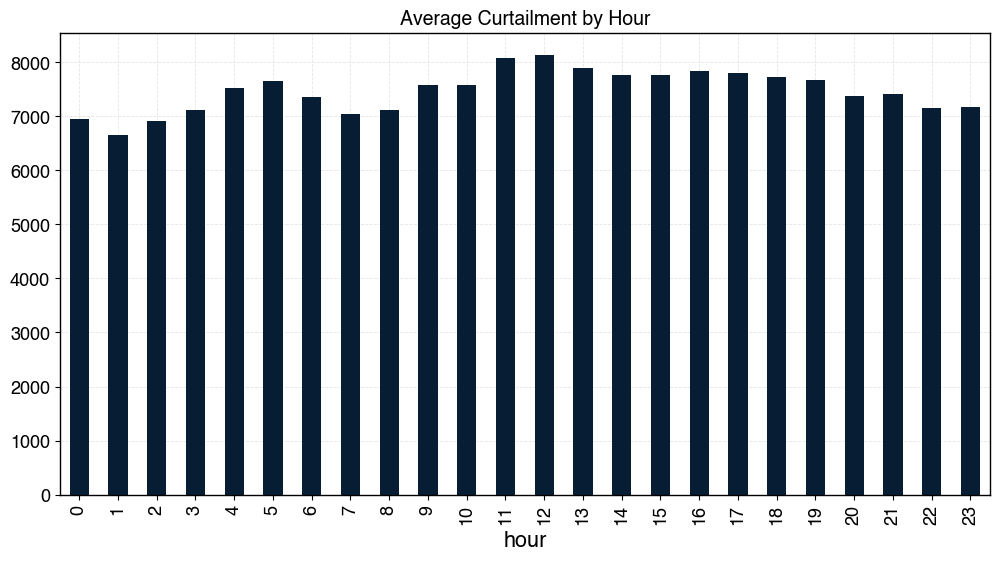

In [117]:
plt.figure(figsize=(12, 6))

# Group by hour and calculate mean curtailment
ts_combined.groupby('hour')['curtailment_energy_kwh'].mean().plot(kind='bar', title='Average Curtailment by Hour')


## Quantum Heater Specs

| Model No. | Input Rating (W) | Input Rating (kW) | Output Rating (W) | Output Rating (kW) | Boost Mode (W) | Boost Mode (kW) | Max Storage (Wh) | Max Storage (kWh) |
| --------- | ---------------- | ----------------- | ----------------- | ------------------ | -------------- | --------------- | ---------------- | ----------------- |
| QM050RF   | 1020             | 1.02              | 500               | 0.50               | 340            | 0.34            | 7140             | 7.14              |
| QM070RF   | 1560             | 1.56              | 700               | 0.70               | 520            | 0.52            | 10920            | 10.92             |
| QM100RF   | 2220             | 2.22              | 1000              | 1.00               | 740            | 0.74            | 15540            | 15.54             |
| QM125RF   | 2760             | 2.76              | 1250              | 1.25               | 920            | 0.92            | 19320            | 19.32             |
| QM150RF   | 3300             | 3.30              | 1500              | 1.50               | 1100           | 1.10            | 23100            | 23.10             |

---

In [121]:
'''
| Model No. | Input Rating (+5%/-10%) | Output Rating (kW) | Boost Mode Rating (kW) | Maximum Storage Capacity (kWh) |
| --------- | ----------------------- | ------------------ | ---------------------- | ------------------------------ |
| QM050RF   | 1.02 kW                 | 0.50 kW            | 0.34 kW                | 7.14 kWh                       |
| QM070RF   | 1.56 kW                 | 0.70 kW            | 0.52 kW                | 10.92 kWh                      |
| QM100RF   | 2.22 kW                 | 1.00 kW            | 0.74 kW                | 15.54 kWh                      |
| QM125RF   | 2.76 kW                 | 1.25 kW            | 0.92 kW                | 19.32 kWh                      |
| QM150RF   | 3.30 kW                 | 1.50 kW            | 1.10 kW                | 23.10 kWh                      |
'''

# Heater specs dictionary (already defined)
q_heater = {
    500:  {'input_rating': 1.02, 'output_rating': 0.50, 'boost_mode_rating': 0.34, 'max_storage_capacity': 7.14},
    700:  {'input_rating': 1.56, 'output_rating': 0.70, 'boost_mode_rating': 0.52, 'max_storage_capacity': 10.92},
    1000: {'input_rating': 2.22, 'output_rating': 1.00, 'boost_mode_rating': 0.74, 'max_storage_capacity': 15.54},
    1250: {'input_rating': 2.76, 'output_rating': 1.25, 'boost_mode_rating': 0.92, 'max_storage_capacity': 19.32},
    1500: {'input_rating': 3.30, 'output_rating': 1.50, 'boost_mode_rating': 1.10, 'max_storage_capacity': 23.10}
}

## Load Shifting Analyis

### Model overengineered hahaha

* Assumptions:
    * adoption_rate = 10% of households
    * total_households = 10,320 → adopted_households = 1,032

* Heater configurations per scenario:
    * low: 1 heater (QM700) → capacity: 10.92 kWh, output: 0.70 kW
    * mid: 2 heaters (QM700 + QM1250) → capacity: 30.24 kWh, output: 1.95 kW
    * high: 3 heaters (QM700 + QM1250 + QM500) → capacity: 37.38 kWh, output: 2.45 kW

* Charging logic:
    * Quantum heaters charge using curtailed wind energy
    * Charging per interval is limited by:
        - available curtailed energy (Curtailment_kwh)
        - max input rating per home × 0.5 h × adopted households
        - available thermal storage remaining at that time
    * Heaters can charge at any hour (no off-peak limitation) since Kaluza responds to real-time curtailment signals
    * Energy charged per interval is added to the cumulative storage, capped by max storage

* Depletion logic (thermal energy usage):
    * Heaters deplete stored thermal energy only during “heating-active” intervals:
        - Weekdays: 06:00–08:30 and 16:00–23:00 (customisable)
    * Actual depletion rate per interval is based on:
        - total output rating of installed heaters (kW per home)
        - a seasonal and insulation-based usage multiplier
        - output rating × 0.5 h × usage factor × adopted households
        - cannot exceed current stored energy
    * Storage is reduced each interval by the depleted amount

* Season-based output usage factors:
    * Used to scale heater output according to realistic seasonal usage
    * Based on average insulation level of the homes

    | Season   | Poor Insulation | Average Insulation | Good Insulation |
    |----------|------------------|--------------------|-----------------|
    | Winter   | 1.0              | 0.8                | 0.6             |
    | Autumn   | 0.7              | 0.5                | 0.35            |
    | Spring   | 0.6              | 0.4                | 0.3             |
    | Summer   | 0.3              | 0.15               | 0.1             |

* Storage state update per 30-minute interval:
    * current_storage = previous_storage + charged_kwh - depleted_kwh
    * storage is bounded between 0 and max_storage
    * modeled cumulatively across time (not reset daily)

* Output metrics:
    * absorbed_kwh: curtailed energy absorbed by heaters
    * depleted_kwh: thermal energy used for space heating
    * remaining_storage_kwh: current available energy in heaters
    * unabsorbed_curtailment = curtailed_kwh - absorbed_kwh

In [212]:
#



### Simple model

[Heating Energy Usage](https://www.ovoenergy.com/guides/energy-guides/how-much-heating-energy-do-you-use)
[Scotland Specific Heating Energy Usage](https://www.climatexchange.org.uk/wp-content/uploads/2023/09/cxc-expanding-scottish-energy-data-heat-february-22.pdf)

* Heating Energy Usage: 13,321 kwh per annum
* Daily usage (assuming it is use 9 months cause orkney is cold??): 13,321 (kwh/365 mdays)/ (30 days * 9 month) = 49.34 kWh
* Half an hour usage: daily usage (kwh/day(24 hours))/ 48 (30 minute freq) = 1.028 kwh
    * during winter: 90% of load? = 0.93 kwh /30 minute
    * during autumn/spring: 60% of load? = 0.62 kwh / 30 minute
    * during summer: 10% of load? = 0.10 kwh / 30 minute

* Charging/Load Shift
    * when curtailment > 0 kwh the load shift will be charged_kwh = min(curtailment, max_draw_quantum_heater, max_storage-storage)
    * add a new column to carry the charge `qheater_storage` = max(0, min(storage + charged_kwh, max_storage_capacity))



### Model (simplified)

* Assumptions:

  * adoption\_rate = 10% of households
  * total\_households = 10,320 → adopted\_households = 1,032

* Heater configurations:
  * 3 heaters (QM700 + QM1250 + QM1000) [bedroom, living room, kitchen??] → capacity: 45.78 kWh, output: 2.95 kW

* Heating demand assumptions:

  * Annual usage per electric home: 13,321 kWh/year
  * Heating occurs over 9 months (≈270 days)
  * Average daily usage during heating season: ≈ 49.34 kWh/day
  * Baseline half-hour usage: ≈ 1.03 kWh per interval (49.34 ÷ 48)
  * Adjusted seasonal half-hour usage:

    * Winter: 90% → 0.93 kWh
    * Autumn/Spring: 60% → 0.62 kWh
    * Summer: 10% → 0.10 kWh

* Charging logic:

  * When curtailed energy is available (`Curtailment_kwh > 0`), heaters absorb it
  * Charging per interval is limited by:

    * available curtailed energy
    * max input rating per home × 0.5 h × adopted households
    * available thermal storage (max capacity − current storage)
  * Charging can occur at any time of day (no off-peak restrictions)
  * Energy charged is added to cumulative storage, capped at max storage

* Depletion logic (thermal energy usage):

  * Depletion occurs only during “heating-active” intervals:

    * Suggested: 06:00–08:30 and 16:00–23:00
  * Depletion per interval is a fixed seasonal average (see above)
  * Storage is reduced by:

    * min(seasonal\_depletion\_per\_interval, current\_storage)

* Storage state update per 30-minute interval:

  * current\_storage = previous\_storage + charged\_kwh - depleted\_kwh
  * storage is bounded between 0 and max\_storage
  * updated cumulatively over time (not reset daily)

* Output metrics:

  * absorbed\_kwh: curtailed energy absorbed by heaters
  * depleted\_kwh: seasonal thermal usage estimate
  * remaining\_storage\_kwh: heater energy state at each interval
  * unabsorbed\_curtailment = curtailed\_kwh - absorbed\_kwh


In [135]:
half_hour_usage = (13321 / (30*9)) / 48
winter_factor = 0.9
autumn_spring_factor = 0.6
summer_factor = 0.1
print(f'half an hour usage: {half_hour_usage:.2f} kWh')
print(f'Winter usage: {half_hour_usage * winter_factor:.2f} kWh')
print(f'Autumn/Spring usage: {half_hour_usage * autumn_spring_factor:.2f} kWh')
print(f'Summer usage: {half_hour_usage * summer_factor:.2f} kWh')


half an hour usage: 1.03 kWh
Winter usage: 0.93 kWh
Autumn/Spring usage: 0.62 kWh
Summer usage: 0.10 kWh


## Load Shifting Model

In [213]:
q_heater = {
    500:  {'input_rating': 1.02, 'output_rating': 0.50, 'boost_mode_rating': 0.34, 'max_storage_capacity': 7.14},
    700:  {'input_rating': 1.56, 'output_rating': 0.70, 'boost_mode_rating': 0.52, 'max_storage_capacity': 10.92},
    1000: {'input_rating': 2.22, 'output_rating': 1.00, 'boost_mode_rating': 0.74, 'max_storage_capacity': 15.54},
    1250: {'input_rating': 2.76, 'output_rating': 1.25, 'boost_mode_rating': 0.92, 'max_storage_capacity': 19.32},
    1500: {'input_rating': 3.30, 'output_rating': 1.50, 'boost_mode_rating': 1.10, 'max_storage_capacity': 23.10}
}

season_factors = {
    'winter': 0.9,
    'autumn_spring': 0.6,
    'summer': 0.1
}

# adoption rate
qheater_adoption_rate = 0.5

heater_mix = [700, 1000, 1250]

qheater_max_storage_capacity = 0
qheater_max_output = 0 
for type in heater_mix:
    qheater_max_storage_capacity += q_heater[type]['max_storage_capacity']
    qheater_max_output += q_heater[type]['output_rating']

qheater_half_hour_usage = qheater_max_storage_capacity/48

qheater_max_input_rating = sum(q_heater[size]['input_rating'] for size in heater_mix) # kw
qheater_max_energy_draw_per_interval = qheater_max_input_rating * 0.5  # in kWh

print(f'max storage capacity: {qheater_max_storage_capacity:.2f} kWh')
print(f'max output: {qheater_max_output:.2f} kWh')
print(f'30 Minute Heater Usage {qheater_half_hour_usage:.2f} kWh')
print(f'max energy draw per interval: {qheater_max_energy_draw_per_interval:.2f} kWh')

depletion = {
    'Summer': qheater_half_hour_usage * season_factors['summer'],
    'Autumn': qheater_half_hour_usage * season_factors['autumn_spring'],
    'Spring': qheater_half_hour_usage * season_factors['autumn_spring'],
    'Winter': qheater_half_hour_usage * season_factors['winter']
}

depletion

max storage capacity: 45.78 kWh
max output: 2.95 kWh
30 Minute Heater Usage 0.95 kWh
max energy draw per interval: 3.27 kWh


{'Summer': 0.095375,
 'Autumn': 0.5722499999999999,
 'Spring': 0.5722499999999999,
 'Winter': 0.858375}

In [210]:
ts_model = pd.DataFrame(
    data={
        "seasons": ts_combined["season"],
        "hour": ts_combined["hour"],
        "day": ts_combined["day"],
    },
    index=ts_combined.index,
)  # initialize the model with the same index as the combined dataset the adopted households and

# Initialize columns
ts_model['qheater_charging_energy_kwh'] = 0.0
ts_model['qheater_depleted_energy_kwh'] = 0.0
ts_model['qheater_storage_energy_kwh'] = 0.0
ts_model['qheater_curtailment_absorption_ratio'] = 0.0
ts_model['curtailment_unabsorbed_energy_kwh'] = 0.0

# Initialize total storage
previous_storage_kwh = 0.0

# Loop through each 30-minute interval
for i in tqdm.tqdm(range(len(ts_model))):
    current_time = ts_model.index[i]
    current_hour = current_time.hour

    # Get context
    season_label = ts_combined.loc[current_time, 'season']
    curtailment_energy_kwh = ts_combined.loc[current_time, 'curtailment_energy_kwh']
    res_n_households = ts_combined.loc[current_time, 'res_n_households']
    n_adopted_households = res_n_households * qheater_adoption_rate

    # Heating-active hours
    is_heating_active = current_hour in list(range(6, 9)) + list(range(16, 23))
    if is_heating_active:
        qheater_depleted_energy_kwh = min(previous_storage_kwh, depletion[season_label] * n_adopted_households)
    else:
        qheater_depleted_energy_kwh = 0.0

    # Max chargeable energy
    max_draw_kwh = qheater_max_energy_draw_per_interval * n_adopted_households
    available_storage_kwh = max(0,(qheater_max_storage_capacity * n_adopted_households) - previous_storage_kwh)
    qheater_charging_energy_kwh = min(curtailment_energy_kwh, max_draw_kwh, available_storage_kwh)

    # Update total storage
    new_storage_kwh = previous_storage_kwh + qheater_charging_energy_kwh - qheater_depleted_energy_kwh
    new_storage_kwh = max(0.0, min(new_storage_kwh, qheater_max_storage_capacity * n_adopted_households))

    # Absorption ratio and unabsorbed curtailment
    if curtailment_energy_kwh > 0:
        absorption_ratio = qheater_charging_energy_kwh / curtailment_energy_kwh
        curtailment_unabsorbed_kwh = curtailment_energy_kwh - qheater_charging_energy_kwh
    else:
        absorption_ratio = 0.0
        curtailment_unabsorbed_kwh = 0.0

    # Save to DataFrame
    ts_model.loc[current_time, 'qheater_charging_energy_kwh'] = qheater_charging_energy_kwh
    ts_model.loc[current_time, 'qheater_depleted_energy_kwh'] = qheater_depleted_energy_kwh
    ts_model.loc[current_time, 'qheater_storage_energy_kwh'] = new_storage_kwh
    ts_model.loc[current_time, 'qheater_curtailment_absorption_ratio'] = absorption_ratio
    ts_model.loc[current_time, 'curtailment_unabsorbed_energy_kwh'] = curtailment_unabsorbed_kwh

    # Update for next step
    previous_storage_kwh = new_storage_kwh


ts_model.head()


  0%|          | 0/17568 [00:00<?, ?it/s]

100%|██████████| 17568/17568 [00:21<00:00, 815.75it/s]


,seasons,hour,day,qheater_charging_energy_kwh,qheater_depleted_energy_kwh,qheater_storage_energy_kwh,qheater_curtailment_absorption_ratio,curtailment_unabsorbed_energy_kwh
Timestamp,,,,,,,,
2017-01-01 00:00:00,Winter,0,2017-01-01,14199.648,0.0,14199.648,0.543317,11935.4830
2017-01-01 00:30:00,Winter,0,2017-01-01,14202.264,0.0,28401.912,0.537233,12233.6980
2017-01-01 01:00:00,Winter,1,2017-01-01,14202.264,0.0,42604.176,0.529753,12606.9515
2017-01-01 01:30:00,Winter,1,2017-01-01,14202.264,0.0,56806.440,0.525473,12825.3070
2017-01-01 02:00:00,Winter,2,2017-01-01,14202.264,0.0,71008.704,0.524683,12865.9930


Percentage of curtailed energy shifted with adoption rate (0.8%): 19.21%


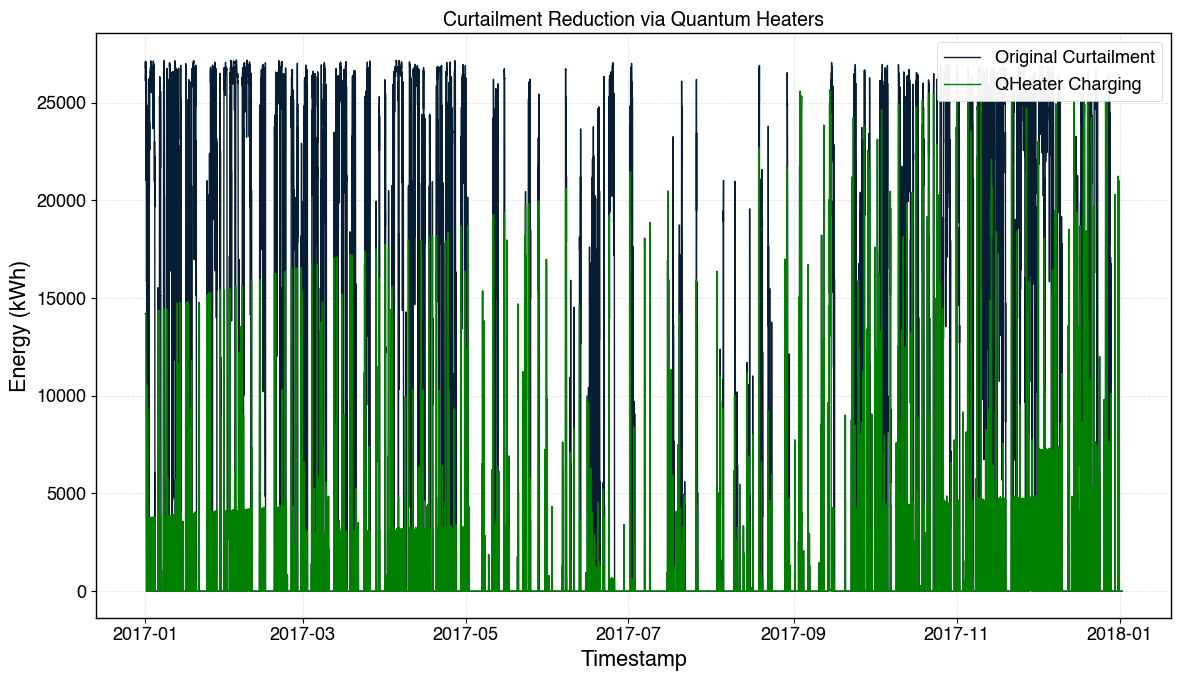

In [211]:
# check overall absoprption ratio')
total_shifted_kwh = ts_model['qheater_charging_energy_kwh'].sum()
total_curtailment_kwh = ts_combined['curtailment_energy_kwh'].sum()

curtailment_shifted_percentage = (total_shifted_kwh / total_curtailment_kwh) * 100
print(f"Percentage of curtailed energy shifted with adoption rate ({qheater_adoption_rate}%): {curtailment_shifted_percentage:.2f}%")

# Plotting the results resampled into monthly intervals

plt.figure(figsize=(12, 7))
plt.plot(ts_model.index, ts_combined['curtailment_energy_kwh'], label='Original Curtailment', linewidth=1)
# plt.plot(ts_model.index, ts_model['curtailment_unabsorbed_energy_kwh'], label='Curtailment Unabsorbed', color='orange', linewidth=1)
plt.plot(ts_model.index, ts_model['qheater_charging_energy_kwh'], label='QHeater Charging', color='green', linewidth=1)


plt.title('Curtailment Reduction via Quantum Heaters')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

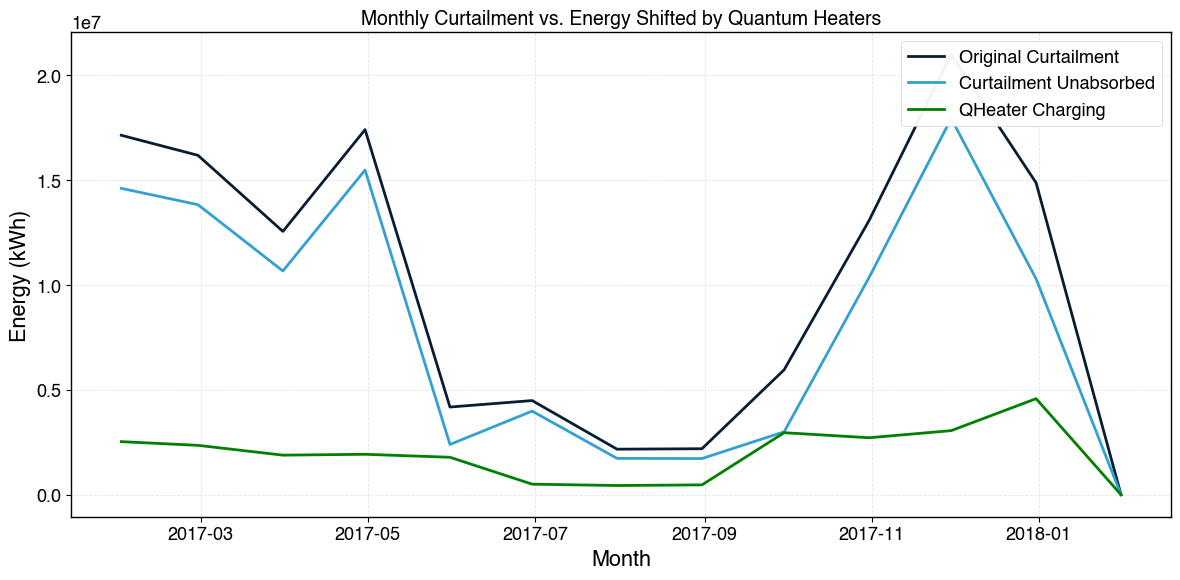

In [209]:
# Resample to monthly sums cause this is energy 
monthly = pd.DataFrame(index=ts_model.resample('ME').sum().index)
monthly['curtailment_energy_kwh'] = ts_combined['curtailment_energy_kwh'].resample('ME').sum()
monthly['qheater_charging_energy_kwh'] = ts_model['qheater_charging_energy_kwh'].resample('ME').sum()
monthly['curtailment_unabsorbed_energy_kwh'] = ts_model['curtailment_unabsorbed_energy_kwh'].resample('ME').sum()


plt.figure(figsize=(12, 6))
plt.plot(monthly.index, monthly['curtailment_energy_kwh'], label='Original Curtailment', linewidth=2)
plt.plot(monthly.index, monthly['curtailment_unabsorbed_energy_kwh'], label='Curtailment Unabsorbed', linewidth=2)
plt.plot(monthly.index, monthly['qheater_charging_energy_kwh'], label='QHeater Charging',color = 'green', linewidth=2)

plt.title('Monthly Curtailment vs. Energy Shifted by Quantum Heaters')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class CurtailmentLoad:
    def __init__(
        self,
        name,
        input_rating,
        max_storage_per_unit,
        adoption_rate,
        has_depletion=False,
        depletion_profile=None,
        has_charging_time=False,
        charging_time=None
    ):
        self.name = name
        self.input_rating = input_rating  # kW
        self.max_storage_per_unit = max_storage_per_unit  # kWh
        self.adoption_rate = adoption_rate

        self.has_depletion = has_depletion
        self.depletion_profile = depletion_profile or {}

        self.has_charging_time = has_charging_time
        self.charging_time = charging_time or []

        self.previous_storage = 0.0

    def deplete(self, is_active, season, n_households):
        if self.has_depletion and is_active:
            depletion = self.depletion_profile.get(season, 0.0)
            depletion_total = depletion * n_households
            depleted = min(self.previous_storage, depletion_total)
            self.previous_storage -= depleted
            return depleted
        return 0.0

    def is_charging_allowed(self, hour):
        if not self.has_charging_time:
            return True
        return hour in self.charging_time

    def charge(self, available_energy, n_households, hour=None):
        if self.has_charging_time and not self.is_charging_allowed(hour):
            return 0.0, self.previous_storage

        max_draw = self.input_rating * 0.5 * n_households
        max_total_storage = self.max_storage_per_unit * n_households
        available_storage = max(0, max_total_storage - self.previous_storage)

        energy_charged = min(available_energy, max_draw, available_storage)
        self.previous_storage += energy_charged
        self.previous_storage = min(self.previous_storage, max_total_storage)

        return energy_charged, self.previous_storage


class EVLoad(CurtailmentLoad):
    def __init__(self, base_soc_ratio=0.3, **kwargs):
        super().__init__(**kwargs)
        self.base_soc_ratio = base_soc_ratio  # e.g., 0.3 = 30%
        self.max_total_storage = self.max_storage_per_unit  # for clarity

    def is_charging_allowed(self, hour):
        return hour in self.charging_time if self.has_charging_time else True

    def charge(self, available_energy, n_households, hour):
        # Reset storage at 18:00 as if cars return home at a fixed SoC
        if hour == 18:
            self.previous_storage = self.base_soc_ratio * self.max_storage_per_unit * n_households

        if not self.is_charging_allowed(hour):
            return 0.0, self.previous_storage

        return super().charge(available_energy, n_households)


In [ ]:
for load in loads:
    